# Modeling Galaxy Formation and Evolution by using Machine Learning

Abstract from the paper:

We present a new exploratory framework to model galaxy formation and evolution
in a hierarchical universe by using machine learning (ML). Our motivations are two-
fold: (1) presenting a new, promising technique to study galaxy formation, and (2)
quantitatively analyzing the extent of the influence of dark matter halo properties
on galaxies in the backdrop of semi-analytical models (SAMs). We use the influential Millennium Simulation and the corresponding Munich SAM to train and test various sophisticated machine learning algorithms (k-Nearest Neighbors, decision trees,
random forests and extremely randomized trees). By using only essential dark matter
halo physical properties for haloes of $M > 10^{12}M_{\odot}$ and a partial merger tree, our
model predicts the hot gas mass, cold gas mass, bulge mass, total stellar mass, black
hole mass and cooling radius at z = 0 for each central galaxy in a dark matter halo
for the Millennium run. Our results provide a unique and powerful phenomenological framework to explore the galaxy-halo connection that is built upon SAMs and
demonstrably place ML as a promising and a computationally efficient tool to study
small-scale structure formation.


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from scipy.stats import kendalltau, spearmanr, pearsonr
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn import decomposition
import pandas as pd
import seaborn as sns
import time
import math
%matplotlib inline

sns.set_style("white")
sns.set_style("ticks")

Make the size of the output cells bigger so that all the figures fit. 

In [5]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Run helper_sam.ipynb. The other notebook has all the helper functions that are used in this notebook for plots and other stuff.

In [6]:
#this notebook has all the helper functions that are used here
#%run '/Users/Ralph/Desktop/astro/45500/final/ml-sims-master/millennium_and_sams/helper_sam.ipynb'
%run helper_sam.ipynb

First, we read in the data. We look at how many haloes there are. We then cut out all the (VERY) extreme outliers (anything greater than the mean by 30 standard deviations). Calculate the base MSE for each mass component and the cooling radius. The base MSE is defined as: $MSE_b = \frac{1}{N_{test}}\sum_{i=1}^{i=N_{test}-1} \left(X_{test}^{i} - X_{mean,train}\right)^2$. We also make a violinplot for the different mass components to see what the distributions look like. 

In [7]:
#df = pd.read_csv('/Users/Ralph/Desktop/astro/45500/final/ml-sims-master/data/data.csv') #load in the data
df = pd.read_csv('../data/data.csv') #load in the data
print(df.shape) 

Q = df.values
M = Q[:,195:201] #mass; need to do this in an iffy way (i.e. not using pandas) because there are duplicate labels

means = np.mean(M, axis=0) 
stds = np.std(M, axis=0)
cutoffs = means + 30*stds #cutoffs to remove extreme outliers

df = df[df.stellarMass < cutoffs[0]][df.coldGas < cutoffs[1]][df.bulgeMass < cutoffs[2]][df.hotGas < cutoffs[3]][df.blackHoleMass < cutoffs[5]] #god bless pandas
print df.shape #just to see how many entries we lost; it turns out to be only 48 out of 350k+ 

Q = df.values #same here; this is really not recommended since
H = Q[:,0:193] #halo inputs; no baryonic quantities are included here
M = Q[:,195:201] #galaxy masses

training_size = 0.35 

H_train, H_test, M_train, M_test = cross_validation.train_test_split(H, M, train_size=training_size, random_state=23) #the random state is chosen for consistency across different runs

HB = np.c_[H, Q[:,193:195], M[:,3], M[:,4]] #halo inputs with cooling radius and hot gas from the last two snapshots
C = np.c_[M[:,1]] #just the cold gas mass

N_train, N_test, C_train, C_test = cross_validation.train_test_split(HB, C, train_size=training_size, random_state=23)

base_mse_st = mse(M_test[:,0], np.mean(M_train[:,0])) 
base_mse_co = mse(M_test[:,1], np.mean(M_train[:,1])) 
base_mse_bu = mse(M_test[:,2], np.mean(M_train[:,2]))
base_mse_ho = mse(M_test[:,3], np.mean(M_train[:,3]))
base_mse_rc = mse(M_test[:,4], np.mean(M_train[:,4]))
base_mse_bh = mse(M_test[:,5], np.mean(M_train[:,5]))

base_mse = np.c_[base_mse_st, base_mse_co, base_mse_bu, base_mse_ho, base_mse_rc, base_mse_bh] 

print('Base MSE for stellar mass is: %f, cold gas mass is: %f, stellar mass in the bulge is: %f, hot gas mass is: %f, cooling radius is: %f and black hole mass is: %f' % (base_mse_st, base_mse_co, base_mse_bu, base_mse_ho, base_mse_rc, base_mse_bh))

titles = ['$M_{\star}$', '$M_{cold}$', '$M_{bulge}$', '$M_{hot}$', '$R_{cooling}$', '$M_{BH}$']

del df
del H, M, HB, C #delete everything from memory because we weren't exactly memory conscious. oops

(365456, 201)
(365408, 201)
Base MSE for stellar mass is: 24.787996, cold gas mass is: 0.526936, stellar mass in the bulge is: 28.165416, hot gas mass is: 64524.910355, cooling radius is: 0.000439 and black hole mass is: 0.000468


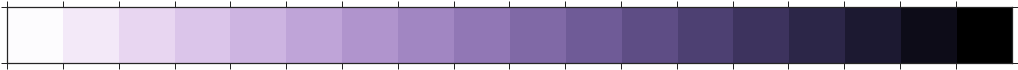

In [8]:
#make a colormap for future plots
sns.palplot(sns.cubehelix_palette(18, start=3, rot=0.1, dark=0, light=0.99))
cold_cmap = sns.cubehelix_palette(18, start=3, rot=0.1, dark=0, light=0.99, as_cmap=True)

↓↓ MACHINE LEARNING STEPS ↓↓

Key idea: We use a variety of supervised techniques to predict the accumulated baryonic mass components at z=0 using solely dark matter halo properties and a partial merger history. 

The paper suggests that machine learning is able to: (1) provide a purely phenomenological framework that is relatively simple and computationally cheap (compared to other galaxy formation models and (2) serve as a unique and useful analysis tool by letting us quantitatively analyze the extent of the influence of dark matter halo properties on small-scale structure in the backdrop of semi-analytical models (SAMs). 

Four techniques are used: kNN, decision trees, random forests and extra trees. 
The base MSE, reduced MSE, the factor reduction (base MSE/reduced MSE), pearson correlation and R^2 are computed and shown to provide a quantitative metric for the robustness of our predictions. 
A hexbin plot with a KDE distribution is plotted for each mass component and the cooling radius for each technique. 
A violinplot, which essentially lets us zoom in to the interesting bits and show a distribution via a KDE, is also plotted for each technique. 

Analysis is redone including the cooling radius and the hot gas mass over the last two snapshots to get a more robust prediction of the cold gas mass using random forests and extra trees. Stellar mass-halo mass relation, the black hole mass-bulge mass relation and the cold gas mass fraction vs stellar mass for the simulated ML galaxies and Guo (2011) galaxies are plotted to show physical reasonability.

--------------------------
↓↓ kNN ↓↓

MSE using kNN for predicting the stellar mass is 6.769575, cold gas mass is 0.400616, bulge mass is 7.144989, hot gas mass is 1324.217570, cooling radius is 0.000081 and black hole mass is 0.000067

Factor reduction (MSE_b/MSE) for kNN for predicting the stellar mass is 3.661677, cold gas mass is 1.315315, bulge mass is 3.941982, hot gas mass is 48.726819, cooling radius is 5.410877 and black hole mass is 6.970379

R^2 score for kNN for predicting the stellar mass is 0.726895, cold gas mass is 0.239718, bulge mass is 0.746315, hot gas mass is 0.979477, cooling radius is 0.815187 and black hole mass is 0.856535

Pearson correlation for kNN for predicting the stellar mass is 0.853520, cold gas mass is 0.490456, bulge mass is 0.865114, hot gas mass is 0.991041, cooling radius is 0.903169 and black hole mass is 0.926284


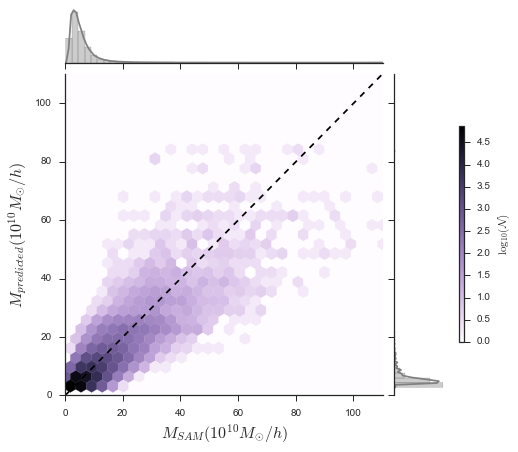

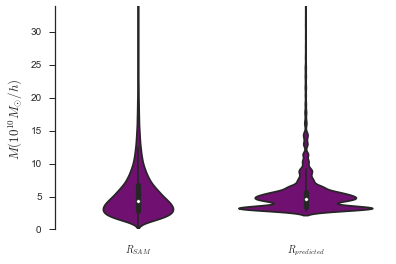

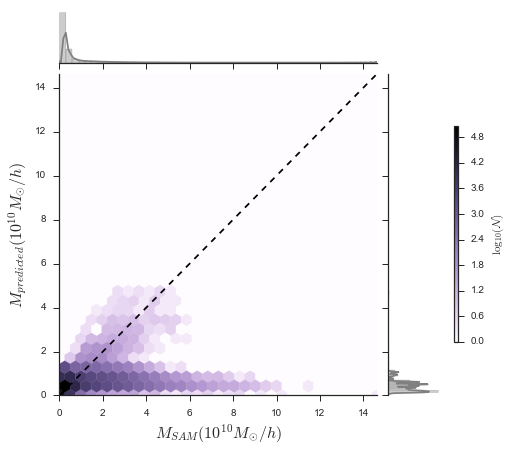

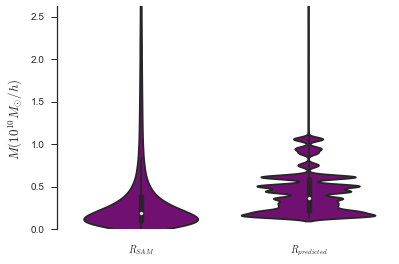

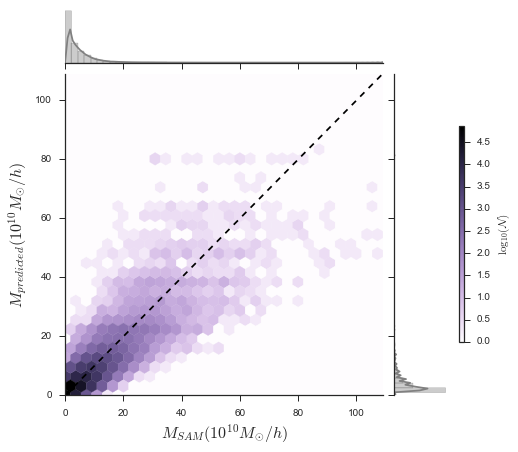

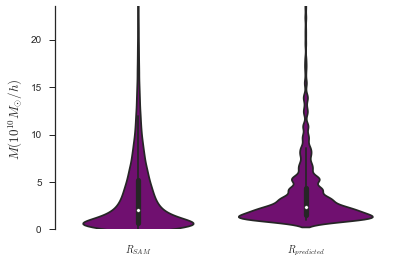

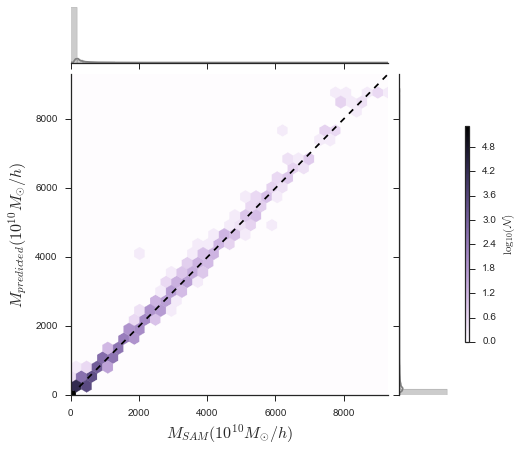

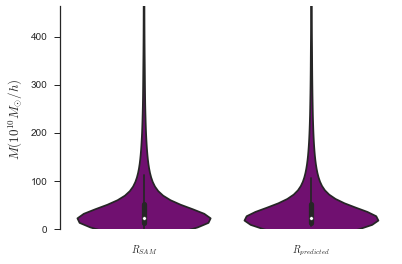

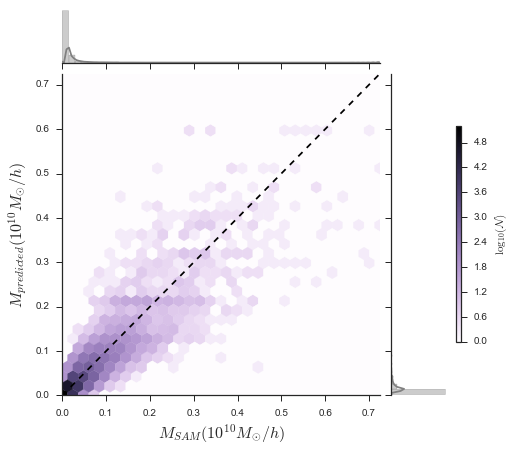

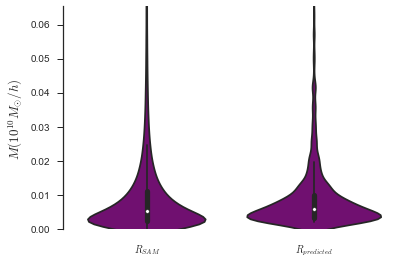

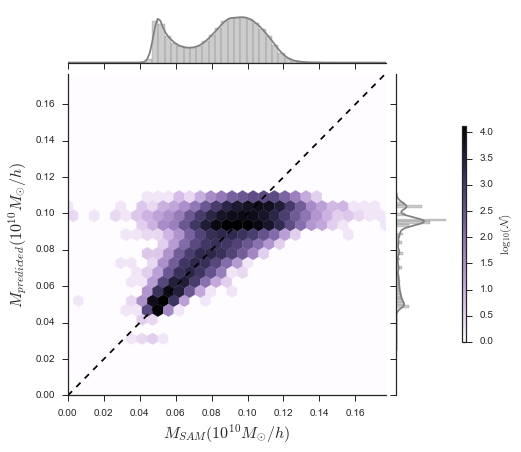

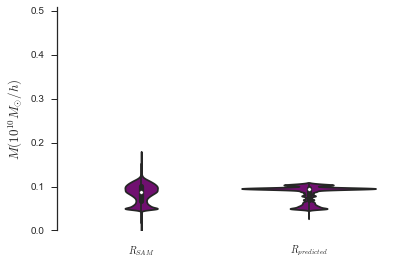

In [9]:
'''
param_dist = {<some parameter space to search over>}
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid=param_dist)
grid_search.fit(B_train, M_train)
report(grid_search.grid_scores_)

Commented out because a full grid search will take too long with such a big multidimensional data set. The report function (in helper.ipynb) will print the 3 best parameter combinations. Included here for completeness. 
'''

knn = KNeighborsRegressor(60, weights='distance') #knn is cool, i guess
M_pred_knn = knn.fit(H_train, M_train).predict(H_test)
mse_knn = mse(M_test, M_pred_knn)
del knn 

print('MSE using kNN for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (mse_knn[0], mse_knn[1],  mse_knn[2], mse_knn[3], mse_knn[4], mse_knn[5]))

base_mse = np.ravel(base_mse)

factors = base_mse/mse_knn

print('Factor reduction (MSE_b/MSE) for kNN for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (factors[0], factors[1],  factors[2], factors[3], factors[4], factors[5])) #TODO: prettier way to print this stuff
print('R^2 score for kNN for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (r2_score(M_test[:,0], M_pred_knn[:,0]), r2_score(M_test[:,1], M_pred_knn[:,1]),  r2_score(M_test[:,2], M_pred_knn[:,2]), r2_score(M_test[:,3], M_pred_knn[:,3]), r2_score(M_test[:,4], M_pred_knn[:,4]), r2_score(M_test[:,5], M_pred_knn[:,5])))
print('Pearson correlation for kNN for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f' % (pearsonr(M_test[:,0], M_pred_knn[:,0])[0], pearsonr(M_test[:,1], M_pred_knn[:,1])[0],  pearsonr(M_test[:,2], M_pred_knn[:,2])[0], pearsonr(M_test[:,3], M_pred_knn[:,3])[0], pearsonr(M_test[:,4], M_pred_knn[:,4])[0], pearsonr(M_test[:,5], M_pred_knn[:,5])[0]))

#[genplots_M(np.c_[M_test[:,i], M_pred_knn[:,i]], mse_knn[i]) for i in [x for x in xrange(0,6) if x != 4]]
#genplots_M(np.c_[M_test[:,4], M_pred_knn[:,4]], mse_knn[4], plot_type='R') 
[genplots_M(np.c_[M_test[:,i], M_pred_dtree[:,i]], mse_dtree[i]) for i in [x for x in xrange(0,6) if x != 4]]
genplots_M(np.c_[M_test[:,4], M_pred_dtree[:,4]], mse_dtree[4]) 

------------------------
↓↓ Decision trees ↓↓

MSE using Decision Trees for predicting the stellar mass is 7.786052, cold gas mass is 0.452259, bulge mass is 8.214749, hot gas mass is 141.131820, cooling radius is 0.000090 and black hole mass is 0.000088

R^2 score using Decision Trees for predicting the stellar mass is 0.685887, cold gas mass is 0.141710, bulge mass is 0.708333, hot gas mass is 0.997813, cooling radius is 0.795914 and black hole mass is 0.812850

Pearson correlation using Decision Trees for predicting the stellar mass is 0.828266, cold gas mass is 0.376456, bulge mass is 0.841706, hot gas mass is 0.998915, cooling radius is 0.892143 and black hole mass is 0.901765


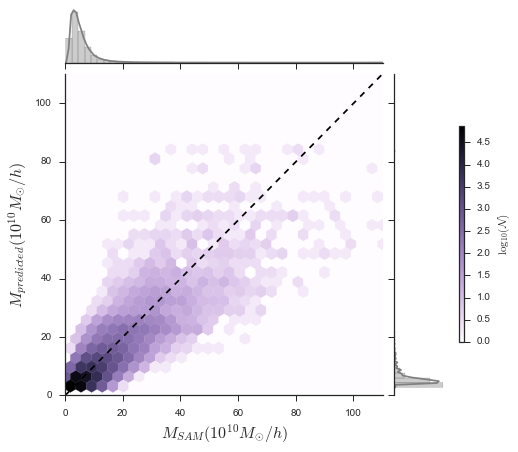

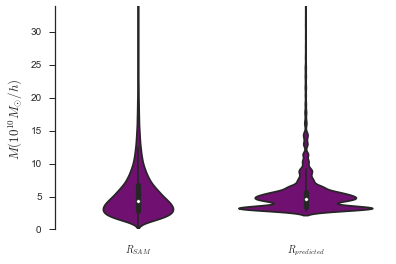

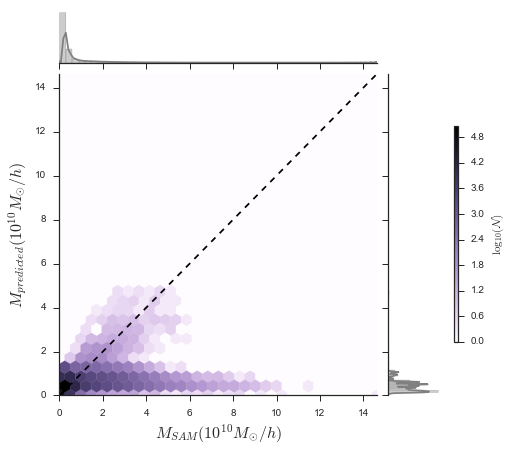

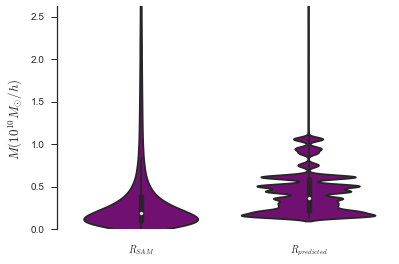

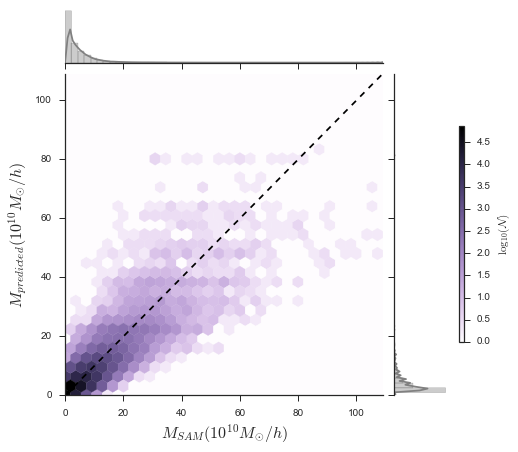

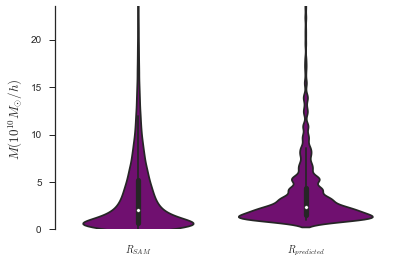

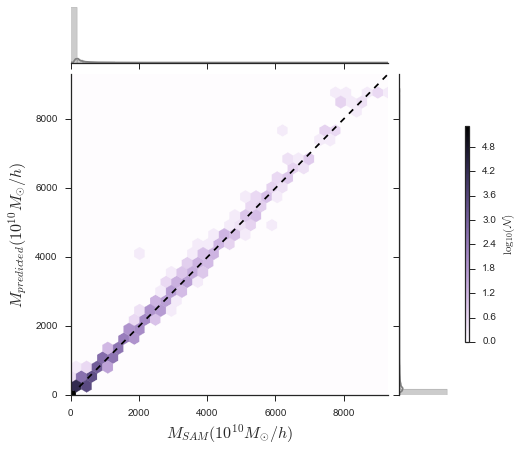

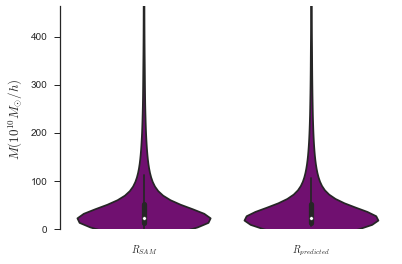

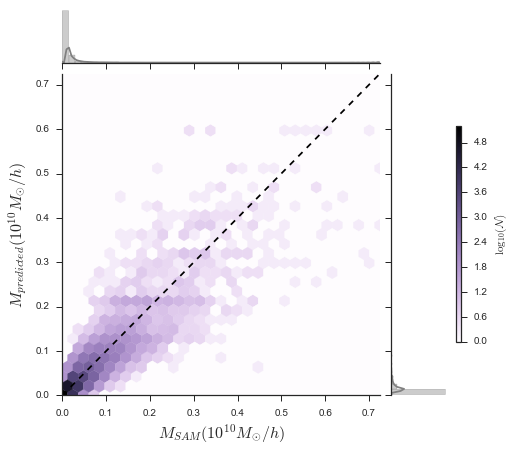

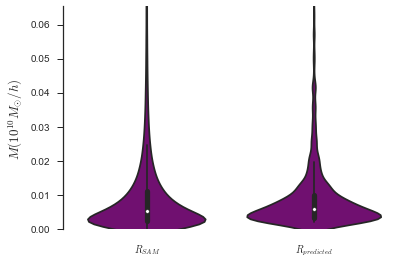

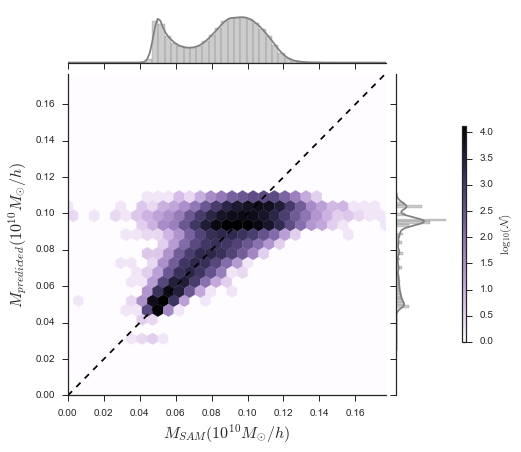

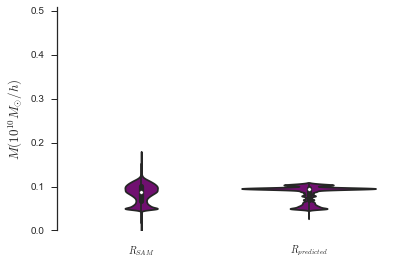

In [7]:
dtree_r = DecisionTreeRegressor(max_depth=8, min_samples_split=4, min_samples_leaf=3) 
M_pred_dtree = dtree_r.fit(H_train, M_train).predict(H_test)
mse_dtree = mse(M_test, M_pred_dtree)
del dtree_r

print('MSE using Decision Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (mse_dtree[0], mse_dtree[1],  mse_dtree[2], mse_dtree[3], mse_dtree[4], mse_dtree[5]))

factors = base_mse/mse_dtree

print('R^2 score using Decision Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (r2_score(M_test[:,0], M_pred_dtree[:,0]), r2_score(M_test[:,1], M_pred_dtree[:,1]),  r2_score(M_test[:,2], M_pred_dtree[:,2]), r2_score(M_test[:,3], M_pred_dtree[:,3]), r2_score(M_test[:,4], M_pred_dtree[:,4]), r2_score(M_test[:,5], M_pred_dtree[:,5])))
print('Pearson correlation using Decision Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f' % (pearsonr(M_test[:,0], M_pred_dtree[:,0])[0], pearsonr(M_test[:,1], M_pred_dtree[:,1])[0],  pearsonr(M_test[:,2], M_pred_dtree[:,2])[0], pearsonr(M_test[:,3], M_pred_dtree[:,3])[0], pearsonr(M_test[:,4], M_pred_dtree[:,4])[0], pearsonr(M_test[:,5], M_pred_dtree[:,5])[0]))

#[genplots_M(np.c_[M_test[:,i], M_pred_dtree[:,i]], mse_dtree[i]) for i in [x for x in xrange(0,6) if x != 4]]
#genplots_M(np.c_[M_test[:,4], M_pred_dtree[:,4]], mse_dtree[4], plot_type='R') 

[genplots_M(np.c_[M_test[:,i], M_pred_dtree[:,i]], mse_dtree[i]) for i in [x for x in xrange(0,6) if x != 4]]
genplots_M(np.c_[M_test[:,4], M_pred_dtree[:,4]], mse_dtree[4]) 

------------------------
↓↓ Random forests ↓↓

MSE using Random Forests for predicting the stellar mass is 5.759959, cold gas mass is 0.319094, bulge mass is 6.300716, hot gas mass is 69.263500, cooling radius is 0.000060 and black hole mass is 0.000067

(24.787995504926457, 0.5269355681906861, 28.165415848649836, 64524.910354855761, 0.00043907639845708227, 0.00046842056682562565)
Factor reduction (MSE_b/MSE) for Random Forests for predicting the stellar mass is 4.303502, cold gas mass is 1.651347, bulge mass is 4.470193, hot gas mass is 931.586052, cooling radius is 7.352837 and black hole mass is 6.966620

R^2 score using Random Forests for predicting the stellar mass is 0.767626, cold gas mass is 0.394428, bulge mass is 0.776291, hot gas mass is 0.998927, cooling radius is 0.863998 and black hole mass is 0.856457

Pearson correlation using Random Forests for predicting the stellar mass is 0.876321, cold gas mass is 0.630573, bulge mass is 0.881187, hot gas mass is 0.999463, cooling radius is 0.929580 and black hole mass is 0.925

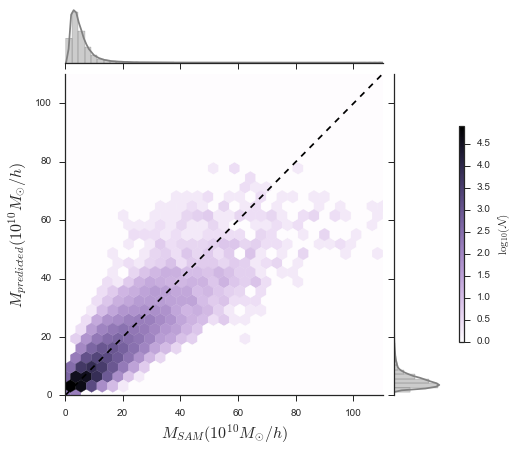

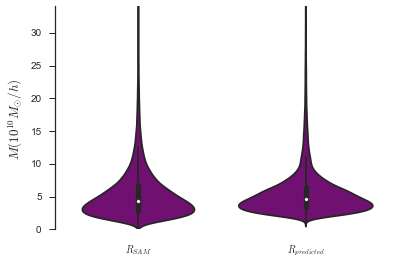

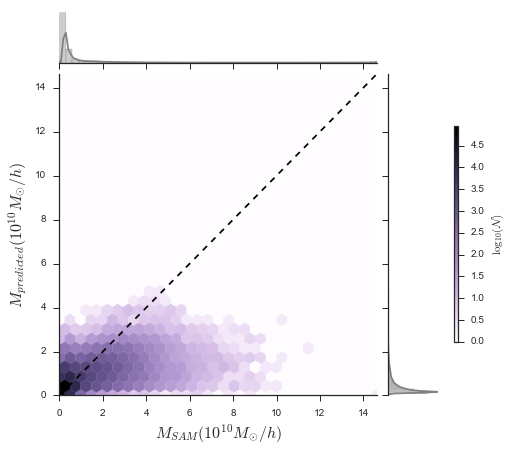

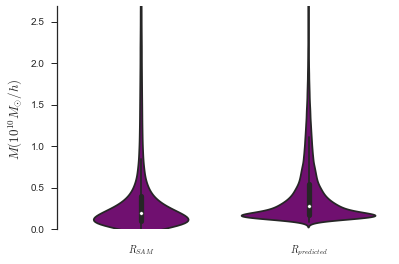

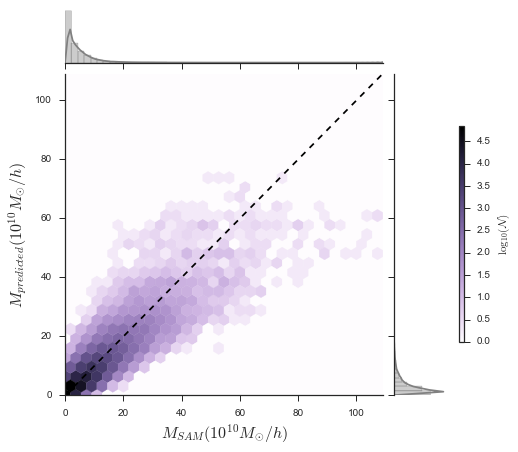

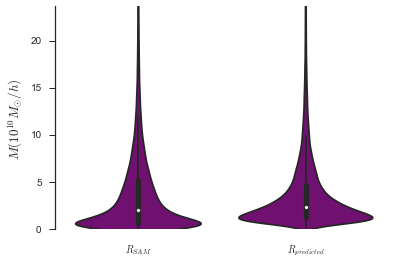

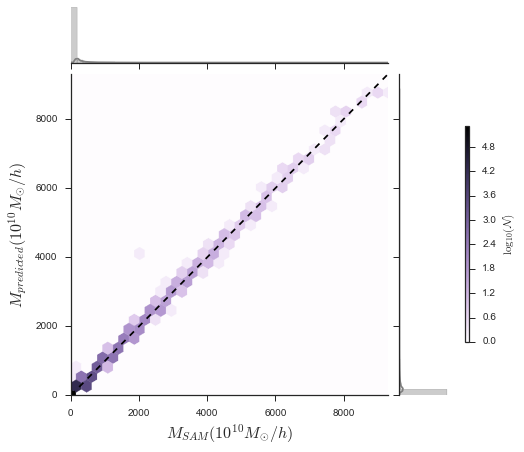

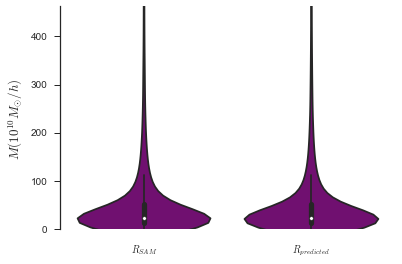

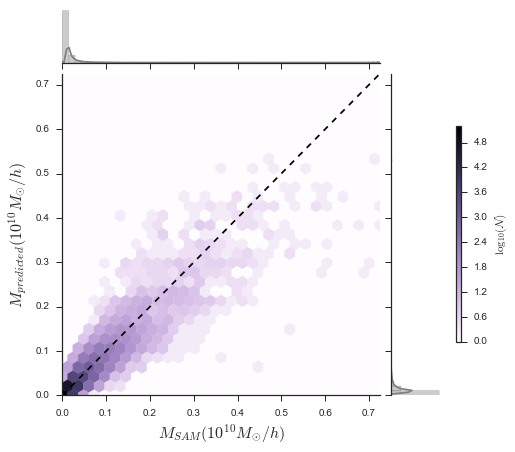

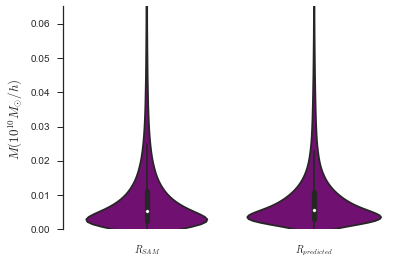

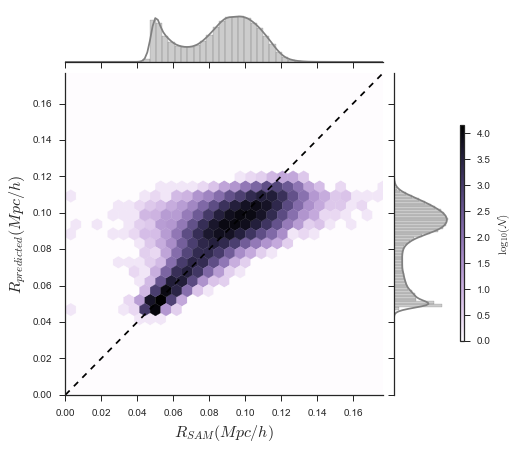

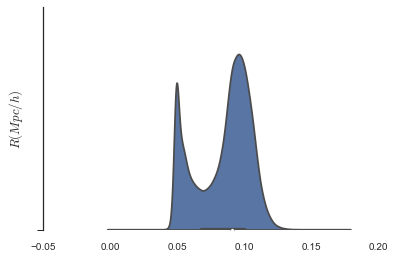

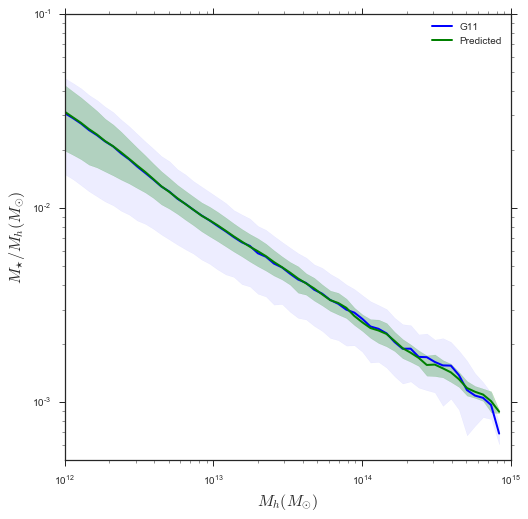

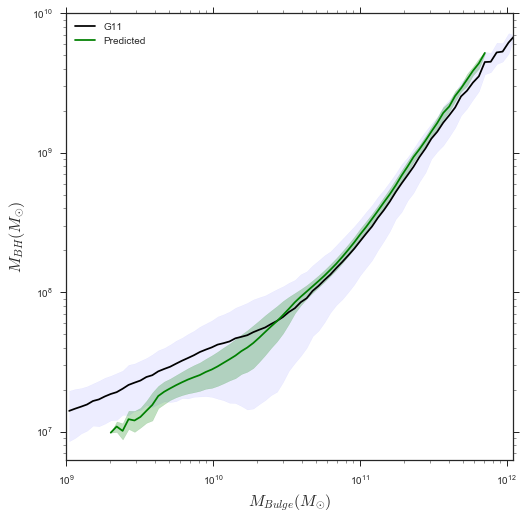

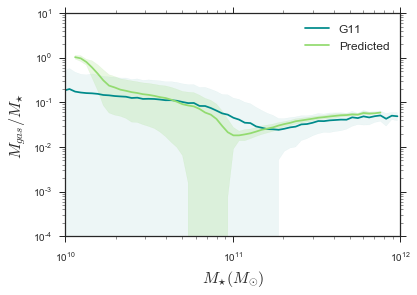

MSE using kNN for predicting the cold gas mass including the baryonic inputs is 0.096999
R^2 score using Random Forests for predicting the cold gas mass including the baryonic inputs is 0.815917
Pearson correlation using Random Forests for predicting the cold gas mass including the baryonic inputs is 0.904877


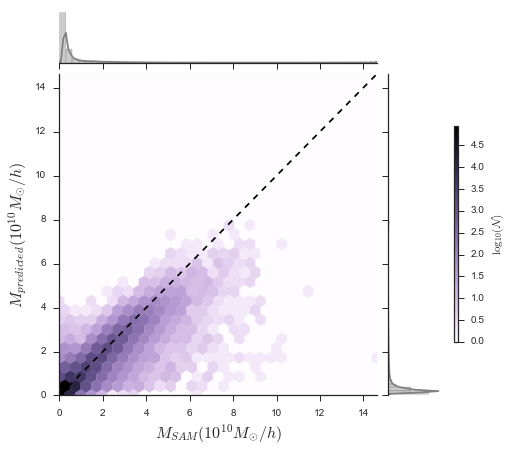

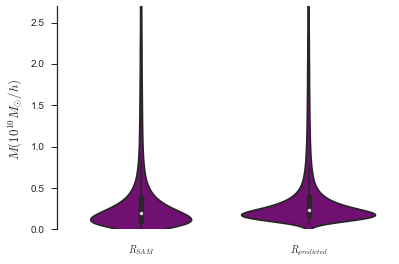

In [8]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, min_samples_split=5, max_features=100)
rf.fit(H_train, M_train)
M_pred_rf = rf.predict(H_test)

mse_rf = mse(M_test, M_pred_rf)

print('MSE using Random Forests for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (mse_rf[0], mse_rf[1], mse_rf[2], mse_rf[3], mse_rf[4], mse_rf[5]))

base_mse = np.s_[base_mse_st, base_mse_co, base_mse_bu, base_mse_ho, base_mse_rc, base_mse_bh] 
print base_mse

factors = base_mse/mse_rf

print('Factor reduction (MSE_b/MSE) for Random Forests for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (factors[0], factors[1],  factors[2], factors[3], factors[4], factors[5])) #TODO: prettier way to print this stuff
print('R^2 score using Random Forests for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (r2_score(M_test[:,0], M_pred_rf[:,0]), r2_score(M_test[:,1], M_pred_rf[:,1]),  r2_score(M_test[:,2], M_pred_rf[:,2]), r2_score(M_test[:,3], M_pred_rf[:,3]), r2_score(M_test[:,4], M_pred_rf[:,4]), r2_score(M_test[:,5], M_pred_rf[:,5])))
print('Pearson correlation using Random Forests for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f' % (pearsonr(M_test[:,0], M_pred_rf[:,0])[0], pearsonr(M_test[:,1], M_pred_rf[:,1])[0],  pearsonr(M_test[:,2], M_pred_rf[:,2])[0], pearsonr(M_test[:,3], M_pred_rf[:,3])[0], pearsonr(M_test[:,4], M_pred_rf[:,4])[0], pearsonr(M_test[:,5], M_pred_rf[:,5])[0]))

[genplots_M(np.c_[M_test[:,i], M_pred_rf[:,i]], mse_rf[i]) for i in [x for x in xrange(0,6) if x != 4]]
genplots_M(np.c_[M_test[:,4], M_pred_rf[:,4]], mse_rf[4], plot_type='R') 

plot_smhm(M_test[:,0], M_pred_rf[:,0], H_test[:,0])
plot_bhbulge(M_test[:,5], M_pred_rf[:,5], M_test[:,2], M_pred_rf[:,2])
plot_coldgasfrac(M_test[:,1], M_pred_rf[:,1], M_test[:,0], M_pred_rf[:,0])

C_train = np.ravel(C_train)
C_test = np.ravel(C_test)

rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, min_samples_split=5)
rf.fit(N_train, C_train)
C_pred_rf = rf.predict(N_test)

mse_rf_mod = mse(C_test,C_pred_rf)

print('MSE using kNN for predicting the cold gas mass including the baryonic inputs is %f' % mse_rf_mod)
print('R^2 score using Random Forests for predicting the cold gas mass including the baryonic inputs is %f' %  r2_score(C_test[:], C_pred_rf[:]))
print('Pearson correlation using Random Forests for predicting the cold gas mass including the baryonic inputs is %f' % pearsonr(C_test[:], C_pred_rf[:])[0])

genplots_M(np.c_[C_test[:],C_pred_rf[:]], mse_rf_mod) 


------------------------
↓↓ Extremely randomized trees ↓↓

MSE using Extra Trees for predicting the stellar mass is 5.757920, cold gas mass is 0.317972, bulge mass is 6.311069, hot gas mass is 58.366519, cooling radius is 0.000059 and black hole mass is 0.000066

Factor reduction (MSE_b/MSE) for Extra Trees for predicting the stellar mass is 4.305026, cold gas mass is 1.657174, bulge mass is 4.462860, hot gas mass is 1105.512403, cooling radius is 7.435172 and black hole mass is 7.070212

R^2 score using Extra Trees for predicting the stellar mass is 0.767708, cold gas mass is 0.396557, bulge mass is 0.775924, hot gas mass is 0.999095, cooling radius is 0.865504 and black hole mass is 0.858561

Pearson correlation using Extra Trees for predicting the stellar mass is 0.876328, cold gas mass is 0.632649, bulge mass is 0.880945, hot gas mass is 0.999549, cooling radius is 0.930412 and black hole mass is 0.926719


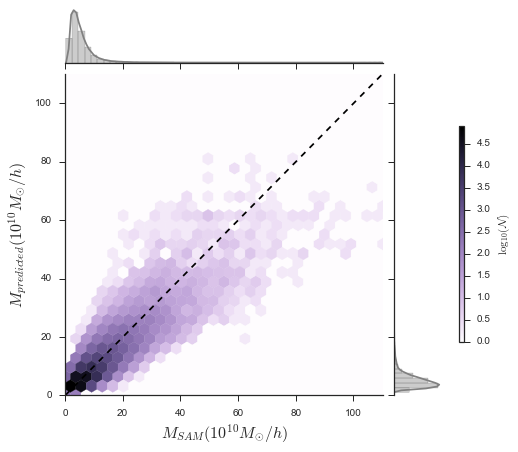

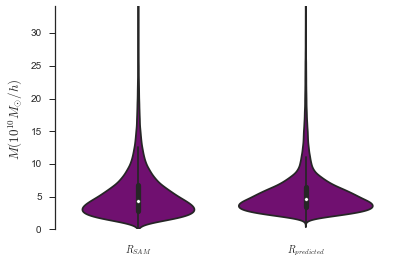

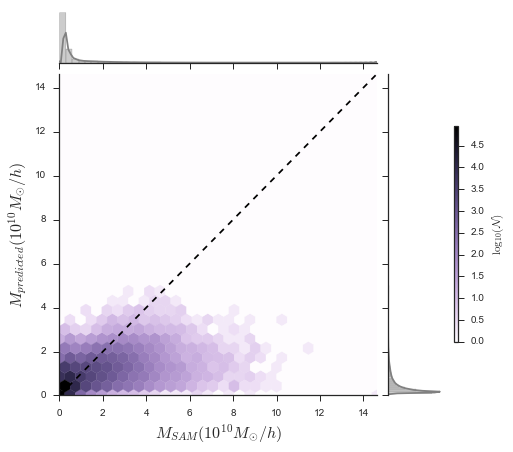

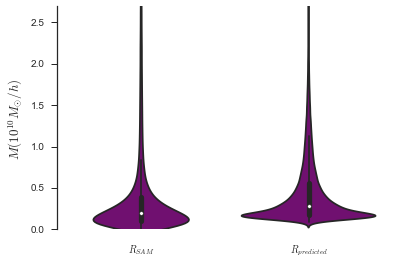

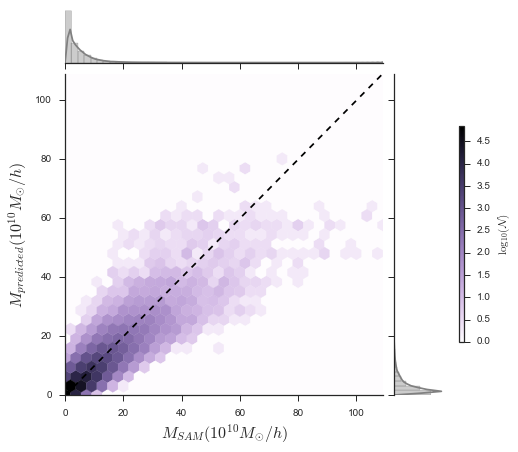

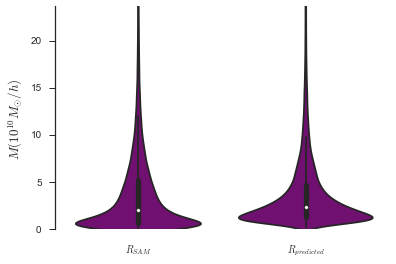

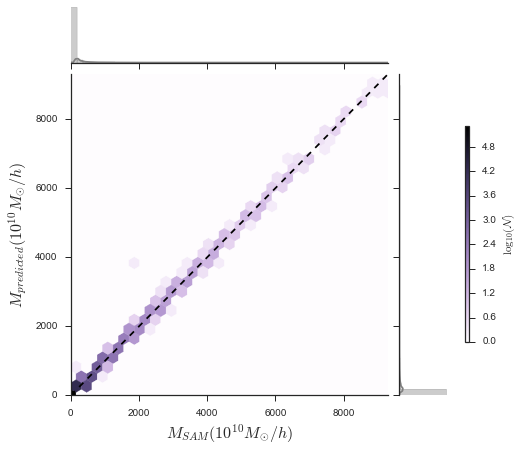

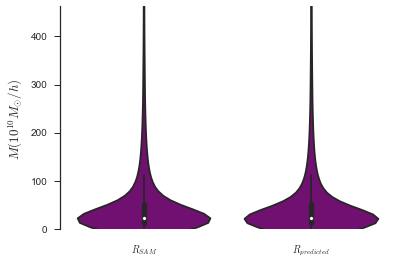

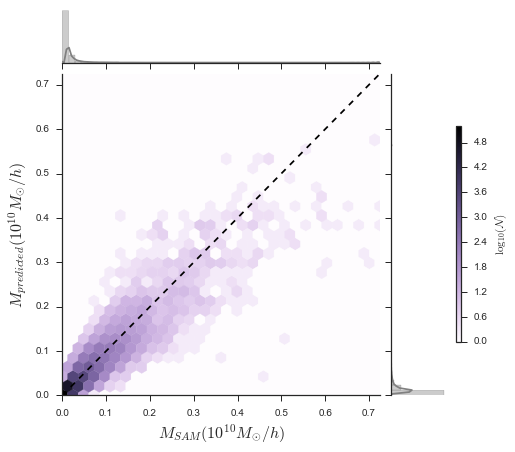

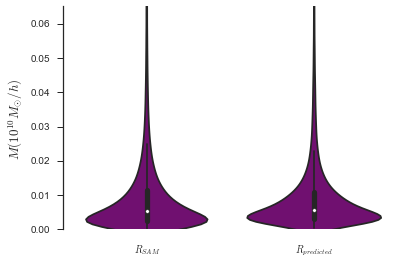

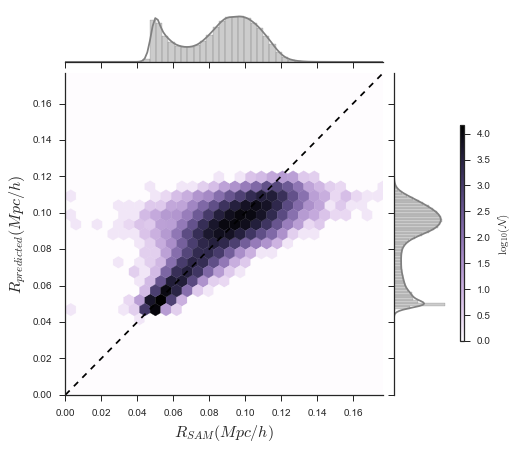

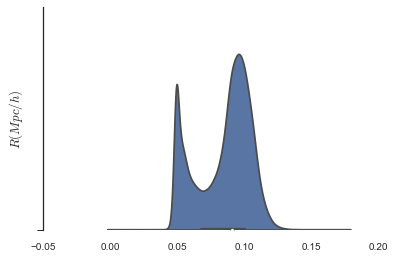

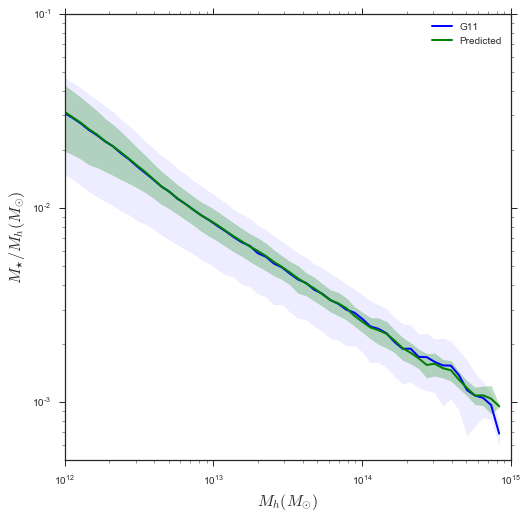

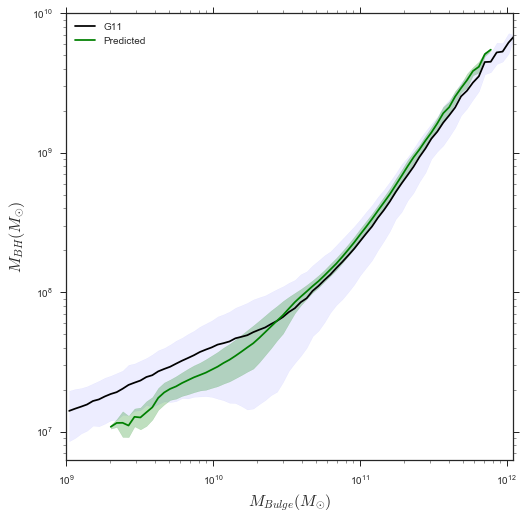

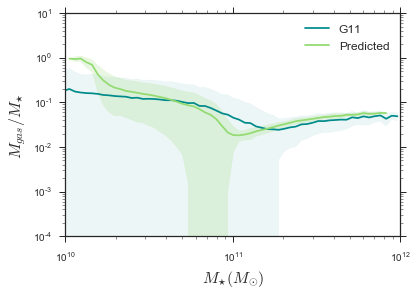

MSE using Extra Trees for predicting the cold gas mass including the baryonic inputs is 0.106477
R^2 score using Extra Trees for predicting the cold gas mass including the baryonic inputs is 0.797929
Pearson correlation using Extra Trees for predicting the cold gas mass including the baryonic inputs is 0.898207


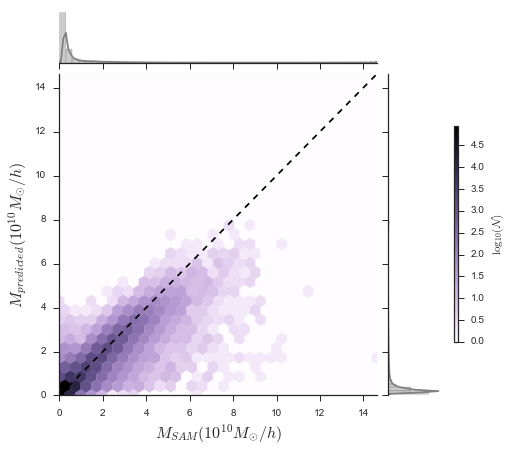

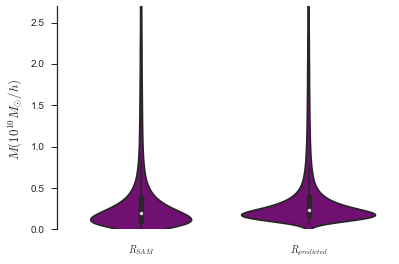

In [11]:
'''
param_dist = {"n_estimators":[43,46,50],
              "max_depth":[10,12,14]
              }
etree = ExtraTreesRegressor()
grid_search = GridSearchCV(etree, param_grid=param_dist)
grid_search.fit(B_train, M_train)

report(grid_search.grid_scores_)
'''
etree = ExtraTreesRegressor(n_estimators=700, min_samples_split=5, n_jobs=-1)
etree.fit(H_train, M_train)
M_pred_etree = etree.predict(H_test)

mse_etree = mse(M_test, M_pred_etree)
del etree

print('MSE using Extra Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (mse_etree[0], mse_etree[1], mse_etree[2], mse_etree[3], mse_etree[4], mse_etree[5]))

factors = base_mse/mse_etree

print('Factor reduction (MSE_b/MSE) for Extra Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (factors[0], factors[1],  factors[2], factors[3], factors[4], factors[5])) #TODO: prettier way to print this stuff
print('R^2 score using Extra Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (r2_score(M_test[:,0], M_pred_etree[:,0]), r2_score(M_test[:,1], M_pred_etree[:,1]),  r2_score(M_test[:,2], M_pred_etree[:,2]), r2_score(M_test[:,3], M_pred_etree[:,3]), r2_score(M_test[:,4], M_pred_etree[:,4]), r2_score(M_test[:,5], M_pred_etree[:,5])))
print('Pearson correlation using Extra Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f' % (pearsonr(M_test[:,0], M_pred_etree[:,0])[0], pearsonr(M_test[:,1], M_pred_etree[:,1])[0],  pearsonr(M_test[:,2], M_pred_etree[:,2])[0], pearsonr(M_test[:,3], M_pred_etree[:,3])[0], pearsonr(M_test[:,4], M_pred_etree[:,4])[0], pearsonr(M_test[:,5], M_pred_etree[:,5])[0]))

[genplots_M(np.c_[M_test[:,i], M_pred_etree[:,i]], mse_etree[i]) for i in [x for x in xrange(0,6) if x != 4]]
genplots_M(np.c_[M_test[:,4], M_pred_etree[:,4]], mse_etree[4], plot_type='R') 

plot_smhm(M_test[:,0], M_pred_etree[:,0], H_test[:,0])
plot_bhbulge(M_test[:,5], M_pred_etree[:,5], M_test[:,2], M_pred_etree[:,2])
plot_coldgasfrac(M_test[:,1], M_pred_etree[:,1], M_test[:,0], M_pred_etree[:,0])

C_train = np.ravel(C_train)
C_test = np.ravel(C_test)

etree = ExtraTreesRegressor(n_estimators=700, n_jobs=-1, min_samples_split=5)
etree.fit(N_train, C_train)
C_pred_etree = etree.predict(N_test)

mse_etree_mod = mse(C_test,C_pred_etree)

print('MSE using Extra Trees for predicting the cold gas mass including the baryonic inputs is %f' % mse_etree_mod)
print('R^2 score using Extra Trees for predicting the cold gas mass including the baryonic inputs is %f' %  r2_score(C_test[:], C_pred_etree[:]))
print('Pearson correlation using Extra Trees for predicting the cold gas mass including the baryonic inputs is %f' % pearsonr(C_test[:], C_pred_etree[:])[0])

genplots_M(np.c_[C_test[:],C_pred_rf[:]], mse_rf_mod)

Using G11 to train the machine learning algorithms, the total stellar mass, stellar mass in the bulge, cold gas mass and hot gas mass in the Millennium simulation are predicted fairly robustly.

------------------------
↓↓ Find the importance of each feature ↓↓

(127892L, 6L)
(237516L, 6L)
['NOX' 'INDUS' 'CRIM' 'CHAS' 'ZN' 'RM']
['$Number$ $of$ $Particles$' '$V_{max}$' '$R_{half}$' '$V_{disp}$' '$Spin$'
 '$M_{crit,200}$']


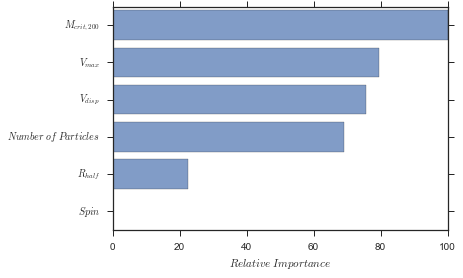

In [10]:
H_train_fi = H_train[:,:5]
H_test_fi = H_test[:,:5]
H_train_fi = np.c_[H_train_fi, H_train[:,8]]
H_test_fi = np.c_[H_test_fi, H_test[:,8]]
print np.shape(H_train_fi)
print np.shape(H_test_fi)
rf = ExtraTreesRegressor(n_estimators=700, n_jobs=-1, min_samples_split=5)
rf.fit(H_train_fi, M_train)
M_pred_rf_fi = rf.predict(H_test_fi)

from sklearn import datasets

#boston = datasets.load_boston()
#print type(boston.feature_names)
#print(boston.feature_names[sorted_idx])

feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

print(boston.feature_names[sorted_idx])

pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center', alpha=0.7)
feature_names = np.array(('$Number$ $of$ $Particles$', '$V_{max}$', '$R_{half}$', '$V_{disp}$', '$Spin$', '$M_{crit,200}$'))
print(feature_names)
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('$Relative$ $Importance$')
plt.savefig('features.pdf', bbox_inches='tight')
plt.show()